In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = True

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# load model
model = LeNet5().eval()
model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))
model = model.to(device)

# test model
dset.test(model, test_loader, args)


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)



# autoencoder

In [3]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.fc1 = nn.Linear(4*8*8, 20)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv3 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)
        self.fc2 = nn.Linear(20, 4*8*8)
        
    def encode(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)   
        x = self.fc1(x.view(-1, 4*8*8))
        return x
        
    def decode(self, x):
        # upsample, followed by a conv layer, with relu activation function  
        # upsample again, output should have a sigmoid applied
        x = self.fc2(x).view(-1,4,8,8)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv3(x))     
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv4(x))                  
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)  
        return x

# initialize the NN
model_a = ConvAutoencoder().to(device)

# load model
model_a.load_state_dict(torch.load('./models/autoencoder/transform+fc'))

In [4]:
model_a = model_a.to(device)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model_a.parameters(), lr=0.0005)

# number of epochs to train the model
num_epochs = 5

losses = []

for epoch in range(1, num_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        inputs, _ = data
        inputs = inputs.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_a(inputs)
        # calculate the loss
        loss = criterion(outputs, inputs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * inputs.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader.dataset)
    print('\rEpoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ), end='')
    losses.append(train_loss)
# save model
# torch.save(model_a.state_dict(), './models/autoencoder/transform+fc')    

Epoch: 5 	Training Loss: 0.009275

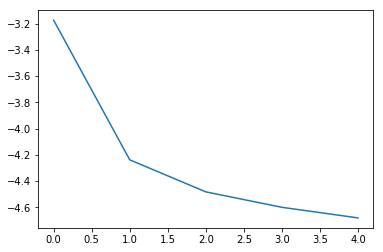

In [5]:
plt.plot(np.log(losses))

In [6]:
test_loss = 0.0
with torch.no_grad():
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        inputs, _ = data
        inputs = inputs.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_a(inputs)
        # calculate the loss
        loss = criterion(outputs, inputs)
        # update running training loss
        test_loss += loss.item() * inputs.size(0)

# print avg training statistics 
test_loss = test_loss/len(test_loader.dataset)
print('\rTest Loss: {:.6f}'.format( 
    test_loss
    ), end='')

Test Loss: 0.056887

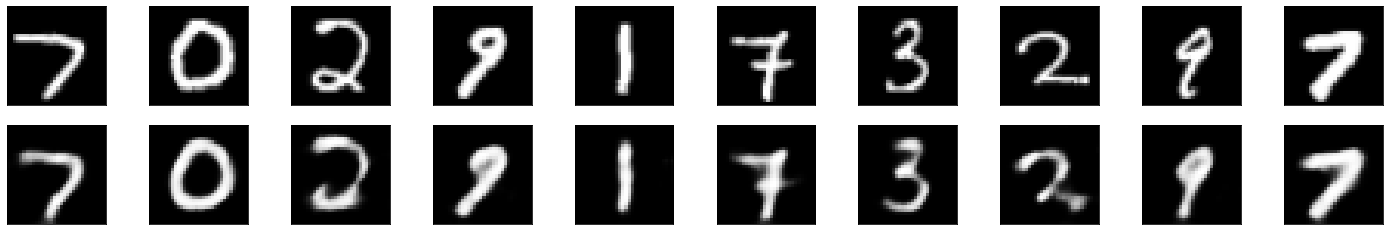

In [7]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[70:80]
model_a = model_a.to('cpu')

# get sample outputs
output = model_a(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(10, 1, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)